# NLP. Week 10. RNN. ELMO

## RNN


### Definition

RNN is a type of artificial neural network designed to recognize patterns in sequences of data, such as time series data, sentences, or video frames. Unlike traditional feedforward neural networks, which process inputs in a single direction (from input to output), RNNs maintain an internal state that allows them to process sequences of inputs.

### Architecture

At each time step, an RNN takes an input vector and its internal state (also known as hidden state) from the previous time step, producing an output vector and updating its internal state. This internal state serves as a memory, enabling RNNs to capture information about previous inputs in the sequence. This recurrent structure makes RNNs suitable for tasks involving sequential data, such as natural language processing (NLP), speech recognition, and time series prediction.

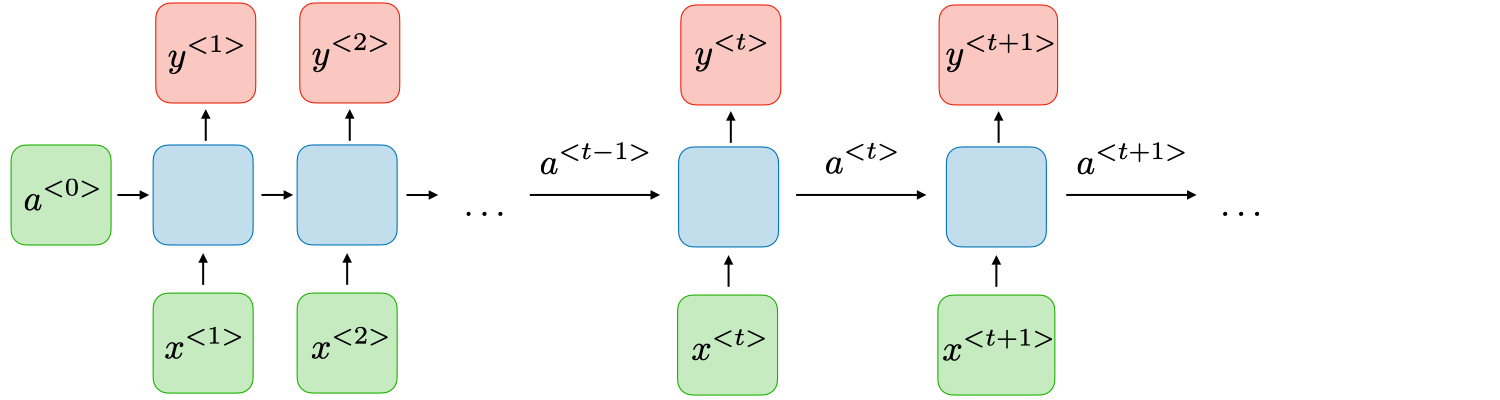

### Training

RNNs are typically trained using backpropagation through time (BPTT), an extension of backpropagation that considers the unfolding of the network over time. However, traditional RNNs suffer from the vanishing gradient problem, where gradients diminish exponentially as they propagate backward through time, limiting their ability to capture long-range dependencies in sequences.

### Variants

To address the limitations of traditional RNNs, several variants have been proposed, including Long Short-Term Memory (LSTM) networks and Gated Recurrent Units (GRUs), which incorporate mechanisms to better capture long-range dependencies and mitigate the vanishing gradient problem.


### Text classification with RNN


In [1]:
import pandas as pd

rating2sentiment = {0.0: 0, 1.0: 0, 2.0: 0, 3.0: 1, 4.0: 2, 5.0: 2}

df = pd.read_csv("/kaggle/input/consumer-reviews-of-amazon-products/1429_1.csv", low_memory=False)
df = df[["reviews.text", "reviews.rating"]]
df.dropna(inplace=True)

df["sentiment"] = df["reviews.rating"].apply(lambda x: rating2sentiment[x])
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/consumer-reviews-of-amazon-products/1429_1.csv'

In [2]:
import re
from tqdm import tqdm
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")


def preprocess_text(s):
    s = s.strip()
    s = s.lower()
    s = re.sub(r"[^a-zA-Z.,!?]+", " ", s)
    s = re.sub(r"\s{2,}", " ", s)
    s = s.strip()
    return s


def build_vocab(dataset):
    for text in tqdm(dataset, desc="Building vocabulary"):
        yield tokenizer(preprocess_text(str(text)))


vocab = build_vocab_from_iterator(
    build_vocab(df["reviews.text"].values),
    max_tokens=25000,
    specials=["<UNK>", "<PAD>"],
    special_first=True,
)
vocab.set_default_index(vocab["<UNK>"])

VOCAB_SIZE = len(vocab)
print("Vocabulary size: ", VOCAB_SIZE)

Building vocabulary: 100%|██████████| 34626/34626 [00:01<00:00, 19072.46it/s]


Vocabulary size:  13457


In [3]:
import torch
import numpy as np
from torch.utils.data import DataLoader

BATCH_SIZE = 16
SEQUENCE_LENGTH = 100


def text_pipeline(text):
    return vocab(tokenizer(preprocess_text(text)))


def collate_fn(batch):
    texts, labels = [], []
    for text, label in batch:
        text_tokens_ids = text_pipeline(text)
        if len(text_tokens_ids) > SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:SEQUENCE_LENGTH]
        elif len(text_tokens_ids) < SEQUENCE_LENGTH:
            text_tokens_ids.extend(
                vocab(["<PAD>" for _ in range(SEQUENCE_LENGTH - len(text_tokens_ids))])
            )

        texts.append(text_tokens_ids)
        labels.append(label)
    texts = torch.tensor(texts, dtype=torch.int)
    labels = torch.tensor(labels, dtype=torch.float)
    return texts, labels


data = np.column_stack((df["reviews.text"].values, df["sentiment"].values))
print(data.shape)
dataloader = DataLoader(
    data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)

(34626, 2)


In [4]:
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers=1):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, h0, c0):
        embedded = self.embedding(text)

        output, (hidden, cell) = self.lstm(embedded, (h0, c0))
        return self.fc(hidden[-1, :, :])

In [5]:
input_dim = VOCAB_SIZE
embedding_dim = 64
hidden_dim = 16
output_dim = 3
n_layers = 5
model = RNN(input_dim, embedding_dim, hidden_dim, output_dim, n_layers=n_layers)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [7]:
from tqdm import tqdm


def train(model, dataloader, optimizer, criterion, device):
    epoch_loss = 0

    model.train()

    for text, labels in tqdm(dataloader):
        text = text.to(device)
        labels = labels.to(device).long()

        optimizer.zero_grad()

        h0 = torch.randn(n_layers, text.shape[0], hidden_dim, device=device)
        c0 = torch.randn(n_layers, text.shape[0], hidden_dim, device=device)
        predictions = model(text, h0, c0)
        loss = criterion(predictions, labels)

        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    return epoch_loss / len(dataloader)

In [8]:
epochs = 3

for epoch in range(epochs):
    train_loss = train(model, dataloader, optimizer, criterion, device)
    print(f"Epoch: {epoch}, Train Loss:  {train_loss} ")

100%|██████████| 2165/2165 [00:10<00:00, 212.91it/s]


Epoch: 0, Train Loss:  0.6185697166391113 


100%|██████████| 2165/2165 [00:09<00:00, 225.94it/s]


Epoch: 1, Train Loss:  0.3488606919592578 


100%|██████████| 2165/2165 [00:09<00:00, 221.95it/s]

Epoch: 2, Train Loss:  0.3032767735955071 


In [9]:
text = "This product is so cool"
tokens = text_pipeline(text)
tokens.extend(vocab(["<PAD>" for _ in range(SEQUENCE_LENGTH - len(tokens))]))
tokens = torch.tensor([tokens]).to(device)
h0 = torch.randn(n_layers, tokens.shape[0], hidden_dim, device=device)
c0 = torch.randn(n_layers, tokens.shape[0], hidden_dim, device=device)
predictions = model(tokens, h0, c0)
predictions.argmax(axis=1).item()

2

## ELMO (Embeddings from Language Models)

### Definition

ELMO is a type of word embedding technique developed by researchers at the Allen Institute for Artificial Intelligence. Unlike traditional word embeddings, which assign a fixed vector representation to each word in a vocabulary, ELMO generates contextualized word embeddings that capture the meaning of a word based on its surrounding context in a sentence.

### Architecture

ELMO is based on a bidirectional language model, typically implemented using a deep neural network such as a bi-directional LSTM. This model is trained on a large corpus of text data to predict the next word in a sentence given its surrounding context. During training, the parameters of the model are adjusted to minimize the prediction error.

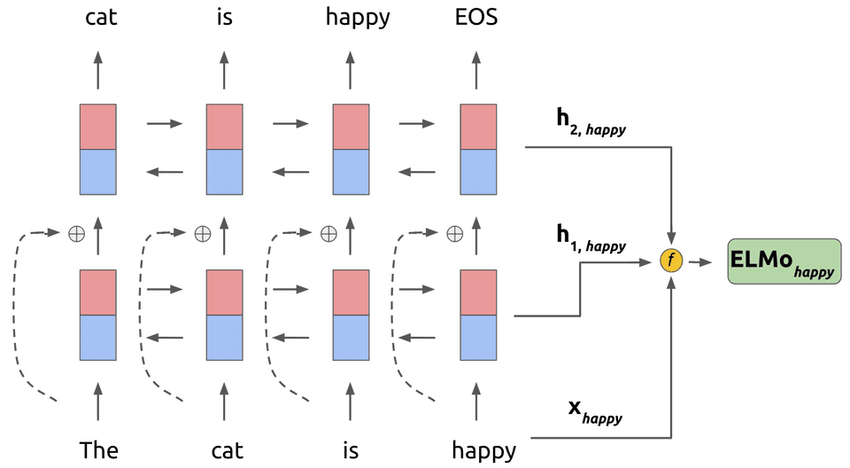

### Contextual Embeddings

After training, the hidden states of the bi-directional LSTM are used to generate word embeddings for downstream NLP tasks. These embeddings are contextualized because they capture information about the entire sentence, allowing them to represent the meaning of a word differently depending on its context.

### Fine-tuning

ELMO embeddings can be fine-tuned for specific tasks by incorporating them into larger neural network architectures and updating their parameters during training on task-specific data. This allows ELMO to adapt to the particular nuances of different tasks and improve performance.

### Implementations and weights

- [Tensorflow1 Hub](https://www.kaggle.com/models/google/elmo/frameworks/tensorFlow1/variations/elmo/versions/1?tfhub-redirect=true) - weights
- [AllenNLP Implementation](https://github.com/allenai/allennlp/blob/main/allennlp/modules/elmo.py) - no longer maintained


## Competition


[Competition](https://www.kaggle.com/t/dd9a97c5c964b1382f9e944c544c66a5)

> Goal of competition is to classify descriptions into categories with use of rnn-based models


In [11]:
df = pd.read_csv("/kaggle/input/nlp-week-10-rnn/train.csv")
df.head()

,class,text
0,12,Rules Changed Up is the debut studio album by...
1,14,Back is a novel written by British writer Hen...
2,14,Love and Glory (ISBN 0-385-29261-9) is a 1983...
3,13,Max Manus: Man of War is a 2008 Norwegian bio...
4,7,The former Ahavas Sholem Synagogue building w...
